In [3]:
import torch
import torch.nn as nn
import timm

class SwinForW3RA(nn.Module):
    def __init__(self, num_inputs=2, num_outputs=1, pretrained=True):
        super(SwinForW3RA, self).__init__()
        
        # Load pretrained Swin model
        self.model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=pretrained,
            in_chans=num_inputs,  # change from 3 (RGB) to 2 (e.g., Sg, Sd)
            num_classes=num_outputs  # regression: num_outputs=1, classification: num_outputs=classes
        )
    
    def forward(self, x):
        return self.model(x)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinForW3RA(num_inputs=2, num_outputs=1).to(device)
print(model)


SwinForW3RA(
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(2, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bi

c:\Users\JR80FD\.conda\envs\swin_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\JR80FD\.cache\huggingface\hub\models--timm--swin_base_patch4_window7_224.ms_in22k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [15]:
import numpy as np

def fourier_positional_encoding(x, D=32, lambda_min=0.01, lambda_max=720.0):
    """
    Encode scalar grid x using sinusoidal Fourier encoding.
    x: [B, H, W]
    Returns: [B, H, W, D]
    """
    x = x.unsqueeze(-1)
    i = torch.arange(0, D // 2, dtype=torch.float32, device=x.device)
    lambdas = torch.exp(torch.log(torch.tensor(lambda_min)) + i * (np.log(lambda_max / lambda_min) / (D // 2 - 1)))
    enc = 2 * np.pi * x / lambdas
    return torch.cat([torch.cos(enc), torch.sin(enc)], dim=-1)  # [B, H, W, D]


In [42]:

import torch

# Simulated parameters
B = 4       # batch size
C = 4       # number of input channels (InSAR, Sd, Sg, S0)
T = 6       # number of past time steps
H = 64      # spatial height
W = 64      # spatial width

# Dummy input: 4 features over 6 time steps
x_input = torch.randn(B, C, T, H, W)

# Dummy target: predict Sg or EWH at time T+1
# y_target = torch.randn(B, 1, H, W)
# Learnable target
y_target = (x_input[:, 0, -1] * 0.3 + x_input[:, 1, -1] * 0.5 + x_input[:, 2, -1] * 0.2).unsqueeze(1)

print("Input shape:", x_input.shape)     # [4, 4, 6, 64, 64]
print("Target shape:", y_target.shape)   # [4, 1, 64, 64]


Input shape: torch.Size([4, 4, 6, 64, 64])
Target shape: torch.Size([4, 1, 64, 64])


In [43]:
# Build dummy lat/lon grid (simulate geographic coverage)
B, _, T, H, W = x_input.shape
lat = torch.linspace(45, 46, H).view(1, H, 1).expand(B, H, W).to(x_input.device)
lon = torch.linspace(9, 10, W).view(1, 1, W).expand(B, H, W).to(x_input.device)

# Encode lat/lon using Fourier features
lat_enc = fourier_positional_encoding(lat, D=32)  # [B, H, W, 32]
lon_enc = fourier_positional_encoding(lon, D=32)  # [B, H, W, 32]
pos_enc = torch.cat([lat_enc, lon_enc], dim=-1)   # [B, H, W, 64]
pos_enc = pos_enc.permute(0, 3, 1, 2)              # [B, 64, H, W]
pos_enc = pos_enc.unsqueeze(2).repeat(1, 1, T, 1, 1)  # [B, 64, T, H, W]

# Concatenate to input
x_input = torch.cat([x_input, pos_enc], dim=1)  # new input: [B, 4+64, T, H, W]


In [44]:


class PatchEmbed3D(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size=(2, 4, 4)):
        super().__init__()
        self.proj = nn.Conv3d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):  # x: [B, C=4, T, H, W]
        x = self.proj(x)   # → [B, embed_dim, T', H', W']
        return x


class SwinBlock3D(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x):  # x: [B, C, T, H, W]
        B, C, T, H, W = x.shape
        x = x.permute(0, 2, 3, 4, 1).reshape(B * T * H * W, C)
        x = self.norm1(x)
        x, _ = self.attn(x.unsqueeze(0), x.unsqueeze(0), x.unsqueeze(0))
        x = self.norm2(x.squeeze(0))
        x = self.mlp(x)
        x = x.view(B, T, H, W, C).permute(0, 4, 1, 2, 3)  # [B, C, T, H, W]
        return x


class Swin3DNet(nn.Module):
    def __init__(self, in_channels=64, embed_dim=32, num_heads=4):
        super().__init__()
        self.patch_embed = PatchEmbed3D(in_channels, embed_dim)
        self.encoder = SwinBlock3D(embed_dim, num_heads)
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(embed_dim, 16, kernel_size=(2, 4, 4), stride=(2, 4, 4)),
            nn.GELU(),
            nn.Conv3d(16, 1, kernel_size=1)  # predict 1 output channel (e.g., Sg at t+1)
        )

    def forward(self, x):  # x: [B, C, T, H, W]
        x = self.patch_embed(x)     # [B, embed_dim, T', H', W']
        x = self.encoder(x)         # same shape
        x = self.decoder(x)         # [B, 1, T, H, W]
        return x[:, :, -1]          # return last time slice only → [B, 1, H, W]


In [45]:
model = Swin3DNet(in_channels=68)  # ← 4 original + 64 position
output = model(x_input)

print("Predicted shape:", output.shape)
assert output.shape == y_target.shape



Predicted shape: torch.Size([4, 1, 64, 64])


In [46]:
import torch.nn as nn
import torch.optim as optim

# Define model (from previous step)
model = Swin3DNet(in_channels=68)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Send data to device
x_input = x_input.to(device)
y_target = y_target.to(device)

# Loss: MSE
criterion = nn.MSELoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [47]:
import torch.optim as optim

# Hyperparameters
num_epochs = 20
learning_rate = 0.001

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss function
criterion = nn.L1Loss()  # Same as MAE

# Training loop
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(x_input)               # Forward pass
    loss = criterion(output, y_target)   # Compare prediction with target
    loss.backward()                      # Compute gradients
    optimizer.step()                     # Update weights

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}")


Epoch [1/20] - Loss: 0.5180
Epoch [2/20] - Loss: 0.5154
Epoch [3/20] - Loss: 0.5128
Epoch [4/20] - Loss: 0.5099
Epoch [5/20] - Loss: 0.5069
Epoch [6/20] - Loss: 0.5038
Epoch [7/20] - Loss: 0.5005
Epoch [8/20] - Loss: 0.4974
Epoch [9/20] - Loss: 0.4948
Epoch [10/20] - Loss: 0.4932
Epoch [11/20] - Loss: 0.4931
Epoch [12/20] - Loss: 0.4944
Epoch [13/20] - Loss: 0.4956
Epoch [14/20] - Loss: 0.4956
Epoch [15/20] - Loss: 0.4945
Epoch [16/20] - Loss: 0.4932
Epoch [17/20] - Loss: 0.4926
Epoch [18/20] - Loss: 0.4931
Epoch [19/20] - Loss: 0.4937
Epoch [20/20] - Loss: 0.4938


In [54]:
import matplotlib.pyplot as plt

# 1️⃣ Plot InSAR time series at one pixel
def plot_timeseries_at_pixel(data, pixel_coords=(32, 32), channel_index=0, label='Variable'):
    """
    Plot the time series at a specific pixel for a given input channel (e.g., InSAR).
    data: Tensor of shape [B, C, T, H, W]
    """
    B, C, T, H, W = data.shape
    plt.figure(figsize=(8, 4))
    for b in range(B):
        ts = data[b, channel_index, :, pixel_coords[0], pixel_coords[1]].cpu().numpy()
        plt.plot(range(T), ts, label=f'Batch {b+1}')
    plt.title(f'Time Series of {label} at Pixel {pixel_coords}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 2️⃣ Plot predicted Sg(t+1) vs true Sg(t+1) at one pixel
def plot_prediction_at_pixel(x_input, y_target, output, pixel=(32, 32), batch_idx=0):
    """
    Plot InSAR input + true Sg(t+1) and predicted Sg(t+1) at a pixel.
    x_input: [B, C, T, H, W] (channel 0 = InSAR)
    y_target: [B, 1, H, W]
    output: [B, 1, H, W]
    """
    insar_ts = x_input[batch_idx, 0, :, pixel[0], pixel[1]].cpu().numpy()
    sg_true = y_target[batch_idx, 0, pixel[0], pixel[1]].cpu().numpy()
    sg_pred = output[batch_idx, 0, pixel[0], pixel[1]].detach().cpu().numpy()

    plt.figure(figsize=(8, 5))
    plt.plot(range(len(insar_ts)), insar_ts, label='InSAR Deformation (Input)', marker='o')
    plt.axvline(x=len(insar_ts), linestyle='--', color='gray')
    plt.plot([len(insar_ts)], [sg_true], 'go', label='True Sg t+1')
    plt.plot([len(insar_ts)], [sg_pred], 'ro', label='Predicted Sg t+1')
    plt.title(f'InSAR to Sg(t+1) Prediction at Pixel {pixel}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 3️⃣ Plot side-by-side spatial map of true vs predicted Sg
def plot_sg_comparison(sg_true, sg_pred, batch_index=0):
    """
    Compare predicted and true Sg(t+1) spatially.
    sg_true, sg_pred: tensors [B, 1, H, W]
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(sg_true[batch_index, 0].cpu().numpy(), cmap='viridis')
    axs[0].set_title('Sg Ground Truth (t+1)')
    axs[0].axis('off')

    axs[1].imshow(sg_pred[batch_index, 0].detach().cpu().numpy(), cmap='magma')
    axs[1].set_title('Sg Prediction (t+1)')
    axs[1].axis('off')

    plt.suptitle(f'Sg Map Comparison - Batch {batch_index}')
    plt.tight_layout()
    plt.show()


# 4️⃣ Plot all time-step maps for a single variable
def plot_spatiotemporal_maps(data, channel_index=0, batch_index=0, title='Channel'):
    """
    Plot maps across time for a single variable (e.g., InSAR or W3RA).
    data: [B, C, T, H, W]
    """
    B, C, T, H, W = data.shape
    fig, axs = plt.subplots(1, T, figsize=(3*T, 3))
    for t in range(T):
        axs[t].imshow(data[batch_index, channel_index, t].cpu().numpy(), cmap='gray')
        axs[t].set_title(f'Time {t}')
        axs[t].axis('off')
    plt.suptitle(f'{title} Over Time (Batch {batch_index})')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

def show_map_with_values(tensor_2d, title='Map with Values'):
    """
    Visualize a 2D tensor as an image with pixel values.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(tensor_2d.cpu().numpy(), cmap='viridis')
    for i in range(tensor_2d.shape[0]):
        for j in range(tensor_2d.shape[1]):
            ax.text(j, i, f"{tensor_2d[i, j]:.1f}", ha='center', va='center', fontsize=6, color='white')
    ax.set_title(title)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()



🔹 Plotting InSAR time series at pixel (32, 32)


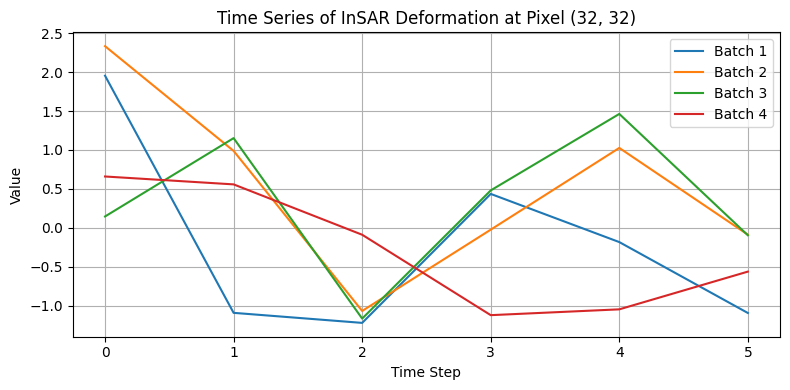

In [50]:
pixel = (32, 32)
print(f"🔹 Plotting InSAR time series at pixel {pixel}")
plot_timeseries_at_pixel(
    data=x_input, 
    pixel_coords=pixel, 
    channel_index=0,  # InSAR is channel 0
    label='InSAR Deformation'
)


🔹 Plotting spatial maps of InSAR deformation over all time steps


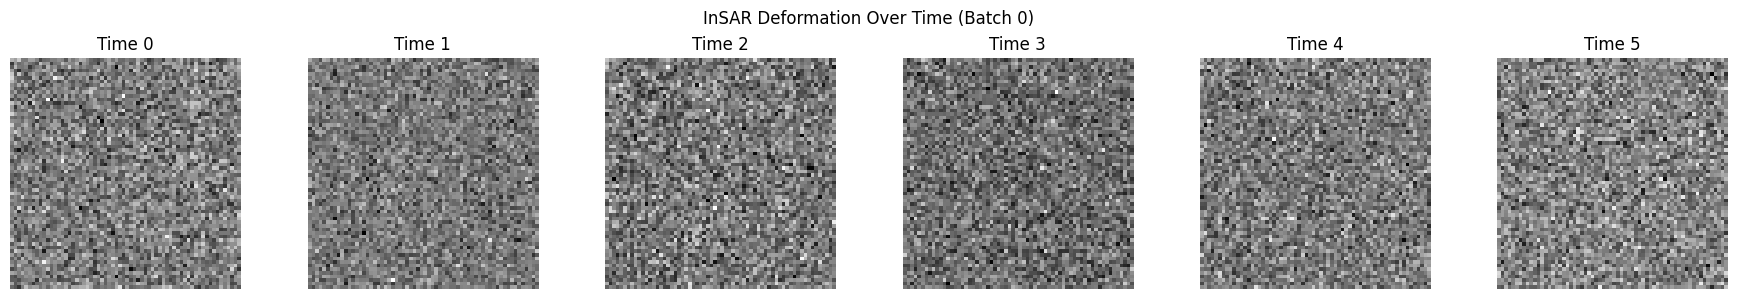

In [51]:
print("🔹 Plotting spatial maps of InSAR deformation over all time steps")
plot_spatiotemporal_maps(
    data=x_input,
    channel_index=0,  # InSAR
    batch_index=0,
    title='InSAR Deformation'
)


🔹 Plotting prediction vs true Sg at pixel (32, 32)


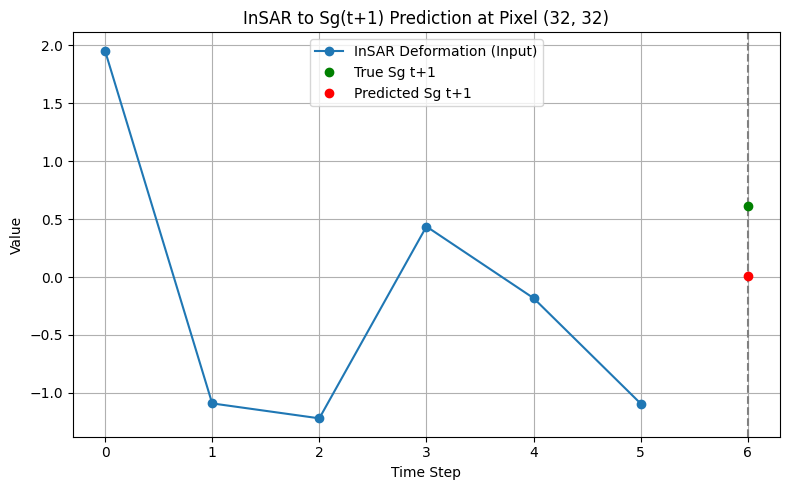

In [52]:
print(f"🔹 Plotting prediction vs true Sg at pixel {pixel}")
plot_prediction_at_pixel(
    x_input=x_input, 
    y_target=y_target, 
    output=output, 
    pixel=pixel, 
    batch_idx=0
)


🔹 Plotting Sg spatial map comparison (true vs predicted)


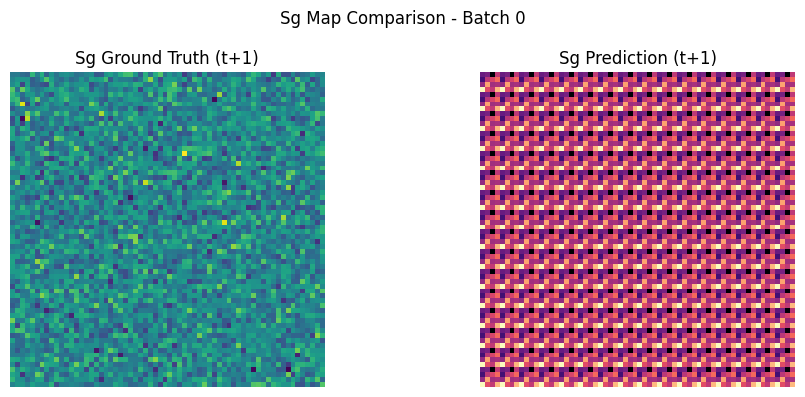

In [53]:
print("🔹 Plotting Sg spatial map comparison (true vs predicted)")
plot_sg_comparison(
    sg_true=y_target, 
    sg_pred=output, 
    batch_index=0
)


In [57]:
show_map_with_values(output_sg[0, 0], title="Predicted Sg t+1")


NameError: name 'output_sg' is not defined